Note my python version:

In [1]:
import sys
print(sys.version)

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]


Packages you'll need:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.ndimage import rotate

%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


# Scatter plot example

### Sampling Data

A function to sample from a bivariate normal distribution with a given rho and sample size n, and map the numbers to the [0, 59] range, so we can later put them in a plot matrix:

In [3]:
def sampleBVN(rho, n=50):
    mean = [0, 0]
    cov = [[1, rho], [rho, 1]]
    bvn = np.random.multivariate_normal(mean, cov, n)
    bvn = (np.round(bvn, 1) * 10 + 30).astype(int)
    bvn[bvn < 0] = 0
    bvn[bvn > 59] = 59
    r, p_val = st.pearsonr(bvn[:, 0], bvn[:, 1])
    sig = p_val < 0.05
    return bvn, r, sig

Sampling 1K samples for significant rhos (0.2 to 0.9, -0.9 to -0.2), keeping results in a pandas DataFrame:

In [4]:
N = 1000
sig_rhos = pd.DataFrame({'rho': np.repeat(np.concatenate((np.linspace(-9, -2, num=8), np.linspace(2, 9, num=8)))/10, N)})
apply_sampleBVN_to_rho = list(zip(*sig_rhos['rho'].apply(sampleBVN)))
sig_rhos['bvn'] = list(apply_sampleBVN_to_rho[0])
sig_rhos['r'] = apply_sampleBVN_to_rho[1]
sig_rhos['sig'] = apply_sampleBVN_to_rho[2]
print(sig_rhos.shape)
sig_rhos.head()

(16000, 4)


,rho,bvn,r,sig
0,-0.9,"[[45, 13], [49, 12], [31, 34], [32, 34], [21, ...",-0.908789,True
1,-0.9,"[[15, 42], [53, 9], [43, 23], [16, 46], [27, 3...",-0.918758,True
2,-0.9,"[[34, 26], [38, 20], [29, 28], [13, 54], [26, ...",-0.929054,True
3,-0.9,"[[28, 36], [27, 22], [31, 33], [35, 33], [45, ...",-0.842864,True
4,-0.9,"[[34, 23], [26, 45], [38, 19], [33, 27], [23, ...",-0.900848,True


Sampling 3K samples for non-significant rhos (-0.1 to 0.1), keeping results in a pandas DataFrame:

In [5]:
N = 3000
non_sig_rhos = pd.DataFrame({'rho': np.repeat(np.linspace(-1, 1, num=3)/10, N)})
apply_sampleBVN_to_rho = list(zip(*non_sig_rhos['rho'].apply(sampleBVN)))
non_sig_rhos['bvn'] = list(apply_sampleBVN_to_rho[0])
non_sig_rhos['r'] = apply_sampleBVN_to_rho[1]
non_sig_rhos['sig'] = apply_sampleBVN_to_rho[2]
print(non_sig_rhos.shape)
non_sig_rhos.head()

(9000, 4)


,rho,bvn,r,sig
0,-0.1,"[[18, 8], [27, 22], [39, 34], [33, 28], [33, 3...",0.102275,False
1,-0.1,"[[45, 52], [31, 29], [38, 11], [36, 37], [12, ...",-0.067681,False
2,-0.1,"[[17, 23], [43, 19], [32, 26], [37, 36], [37, ...",-0.204918,False
3,-0.1,"[[35, 36], [20, 23], [48, 21], [35, 30], [21, ...",-0.085569,False
4,-0.1,"[[29, 25], [24, 34], [30, 47], [30, 34], [28, ...",-0.126296,False


In [6]:
non_sig_rhos.at[0, 'bvn'].shape

(50, 2)

See how many significant and insignificant p_vals out there:

In [7]:
pd.concat([sig_rhos, non_sig_rhos]).groupby('sig').count()

,rho,bvn,r
sig,,,
False,10857,10857,10857
True,14143,14143,14143


Sample 10K from each group and form raw data:

In [8]:
data_raw = pd.concat([sig_rhos, non_sig_rhos]).groupby('sig').apply(pd.DataFrame.sample, n=10000).reset_index(drop=True)
print(data_raw.shape)
data_raw.groupby('sig').count()

(20000, 4)


,rho,bvn,r
sig,,,
False,10000,10000,10000
True,10000,10000,10000


Define a matrix receiving a `bvn` array and turning it into a plot matrix with zeros everywhere and ones where there is a marker. The matrix is in fact a 4D array which is more suitable for deep learning later on:

In [9]:
def plot_mat(bvn):
    m = np.zeros((60, 60))
    m[bvn[:, 0], bvn[:, 1]] = 1
    return m.reshape((1, 60, 60, 1))

See that the matrix when reshaped to 2D is equivalent to a scatter plot of the bivariate normal sample:

In [10]:
res = plot_mat(data_raw.at[0, 'bvn'])
res.shape

(1, 60, 60, 1)

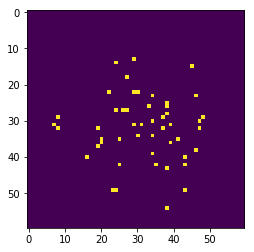

In [11]:
mat2d = rotate(res[0, :, :, 0], 90)
plt.imshow(mat2d, origin='upper')
plt.show()

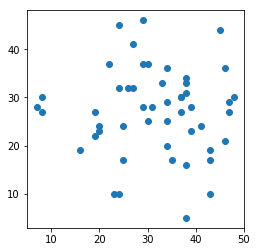

In [12]:
plt.axes().set_aspect('equal')
plt.scatter(data_raw.at[0, 'bvn'][:, 0], data_raw.at[0, 'bvn'][:, 1])
plt.show()

Unite 10K x 2 samples into a giant 20K x 60 x 60 x 1 (color channel) x matrix:

In [13]:
x = np.concatenate(data_raw['bvn'].apply(plot_mat))
x.shape

(20000, 60, 60, 1)

Split to train and test:

In [14]:
train_samp = np.random.choice(x.shape[0], 10000, replace=False)
x_train = x[train_samp, :, :, :]
x_test = x[-train_samp, :, :, :]
print(x_train.shape)
print(x_test.shape)

(10000, 60, 60, 1)
(10000, 60, 60, 1)


### Classification (predicting sig)

Create binary (0: significat, 1: insignificant) y variable:

In [15]:
y_classification = np.repeat([0, 1], 10000)

y_train_cl = y_classification[train_samp]
y_test_cl = y_classification[-train_samp]

Now, for Deep Learning with Keras:

In [16]:
batch_size = 128
epochs = 20
input_shape = (60, 60, 1)

model_cl = Sequential()
model_cl.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_cl.add(Conv2D(64, (3, 3), activation='relu'))
model_cl.add(MaxPooling2D(pool_size=(2, 2)))
model_cl.add(Dropout(0.25))
model_cl.add(Flatten())
model_cl.add(Dense(128, activation='relu'))
model_cl.add(Dropout(0.5))
model_cl.add(Dense(1, activation='sigmoid'))

model_cl.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_cl.fit(x_train, y_train_cl,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2)])

W0730 13:22:15.664162 140433482188608 deprecation_wrapper.py:119] From /home/gioras/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 13:22:15.699960 140433482188608 deprecation_wrapper.py:119] From /home/gioras/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 13:22:15.702299 140433482188608 deprecation_wrapper.py:119] From /home/gioras/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 13:22:15.729820 140433482188608 deprecation_wrapper.py:119] From /home/gioras/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0730 13:22:15.7329

Train on 8000 samples, validate on 2000 samples
Epoch 1/20
8000/8000 [==============================] - 61s 8ms/step - loss: 0.5150 - acc: 0.7354 - val_loss: 0.2791 - val_acc: 0.8850
Epoch 2/20
8000/8000 [==============================] - 63s 8ms/step - loss: 0.3160 - acc: 0.8708 - val_loss: 0.2924 - val_acc: 0.8710
Epoch 3/20
8000/8000 [==============================] - 64s 8ms/step - loss: 0.2290 - acc: 0.9123 - val_loss: 0.2723 - val_acc: 0.8905


In [17]:
score = model_cl.evaluate(x_test, y_test_cl, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2520876467466354
Test accuracy: 0.8977


### Regression (predicting r)

y is now the pearson correlation itself:

In [18]:
y_regression = data_raw['r'].values

y_train_reg = y_regression[train_samp]
y_test_reg = y_regression[-train_samp]

In [19]:
model_reg = Sequential()
model_reg.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_reg.add(Conv2D(64, (3, 3), activation='relu'))
model_reg.add(MaxPooling2D(pool_size=(2, 2)))
model_reg.add(Dropout(0.25))
model_reg.add(Flatten())
model_reg.add(Dense(128, activation='relu'))
model_reg.add(Dropout(0.5))
model_reg.add(Dense(1))

model_reg.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['mean_squared_error'])

model_reg.fit(x_train, y_train_reg,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2)])

Train on 8000 samples, validate on 2000 samples
Epoch 1/20
8000/8000 [==============================] - 70s 9ms/step - loss: 0.0677 - mean_squared_error: 0.0677 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 2/20
8000/8000 [==============================] - 68s 8ms/step - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 3/20
8000/8000 [==============================] - 69s 9ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 4/20
8000/8000 [==============================] - 72s 9ms/step - loss: 0.0185 - mean_squared_error: 0.0185 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 5/20
8000/8000 [==============================] - 67s 8ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0056 - val_mean_squared_error: 0.0056


In [20]:
score = model_reg.evaluate(x_test, y_test_reg, verbose=0)
print('Test MSE:', score[1])

Test MSE: 0.00557349701449275


MSE doesn't tell us much, see predicted r (after capping between -1 and 1) vs. true r:

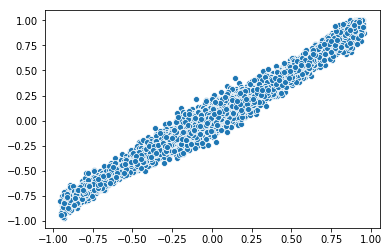

In [26]:
y_pred = model_reg.predict(x_test)[:, 0]
y_pred[y_pred < -1] = -1
y_pred[y_pred > 1] = 1
g = sns.scatterplot(y_test_reg, y_pred)

### Choosing from a Lineup

These functions are from the lineup_examples notebook. The `scale0to59` function will map any continuous coumn of data into the 0 to 59 range so we can can two columns scatter plot into a plot matrix the model can consume:

In [35]:
def scale0to59(x):
    return np.floor(59 * np.round((x - np.min(x)) / (max(x) - min(x)), 2)).astype(int)

def permute_col(df, colname, sample_num=0, permute=True):
    df2 = df.copy()
    df2['.sample'] = sample_num
    if permute:
        df2[colname] = np.random.permutation(df2[colname])
    return df2

def lineup(df, colname, n=20):
    permuted_dfs = [permute_col(df, colname, i) for i in range(n)]
    orig_loc = np.random.choice(n)
    orig_df = permute_col(df, colname, orig_loc, permute=False)
    permuted_dfs[orig_loc] = orig_df
    return pd.concat(permuted_dfs), orig_loc

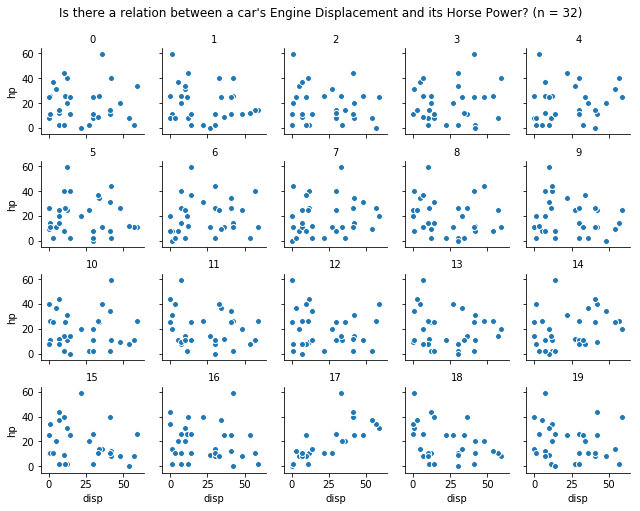

In [45]:
mtcars = pd.read_csv('data/mtcars.csv')
mtcars_0to59 = mtcars.transform(scale0to59)

lineup_mtcars, orig_loc = lineup(mtcars_0to59, 'hp')

g = sns.FacetGrid(lineup_mtcars, col='.sample', col_wrap=5, height=1.8)
g = g.map(plt.scatter, 'disp', 'hp', edgecolor='w').set_titles('{col_name}')
g.fig.suptitle('Is there a relation between a car\'s Engine Displacement and its Horse Power? (n = 32)')
plt.subplots_adjust(top=0.9)

The original model is in plot...

In [46]:
orig_loc

17

What will the `model_cl` predict as the plot with maximum score of being significant?

In [52]:
def convert_data_to_plot_matrix(i):
    return plot_mat(lineup_mtcars[lineup_mtcars['.sample'] == i][['disp', 'hp']].values.astype(int))

x_mtcars = np.concatenate([convert_data_to_plot_matrix(i) for i in range(20)])

y_pred_cl_mtcars = model_cl.predict(x_mtcars)
print(y_pred_cl_mtcars.argmax())

17


What will the `model_reg` predict as the plot with maximum r?

In [53]:
y_pred_reg_mtcars = model_reg.predict(x_mtcars)
print(y_pred_reg_mtcars.argmax())

17


### Adversary Example - non-linear relation